# Transformer 실습

이번 실습에서는 감정 분석 task에 RNN 대신 Transformer를 구현하여 적용해 볼 것입니다.
Library import나 dataloader 생성은 RNN 실습 때와 똑같기 때문에 설명은 넘어가도록 하겠습니다.

In [1]:
!pip install datasets

In [1]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from tokenizers import (
		decoders,
		models,
		normalizers,
		pre_tokenizers,
		processors,
		trainers,
		Tokenizer,
)


ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')


def collate_fn(batch):
	max_len = 400
	texts, labels = [], []
	for row in batch:
		tokenized = tokenizer(row['text'], padding=False, truncation=True, max_length=max_len).input_ids
		labels.append(row['label'])
		texts.append(row['text'])

	texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids)
	labels = torch.LongTensor(labels)

	return texts, labels


train_loader = DataLoader(
		ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
		ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

Using cache found in C:\Users\Sejin/.cache\torch\hub\huggingface_pytorch-transformers_main
c:\Users\Sejin\.conda\envs\PlusAI\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Self-attention

이번에는 self-attention을 구현해보겠습니다.
Self-attention은 shape이 (B, S, D)인 embedding이 들어왔을 때 attention을 적용하여 새로운 representation을 만들어내는 module입니다.
여기서 B는 batch size, S는 sequence length, D는 embedding 차원입니다.
구현은 다음과 같습니다.

In [12]:
from torch import nn
from math import sqrt


class MHA(nn.Module):
	def __init__(self, input_dim, d_model, n_heads):
		super().__init__()

		assert d_model % n_heads == 0, "d_model must be divisible by n_heads" # 준비 1.a

		self.input_dim = input_dim
		self.d_model = d_model
		self.d_model = d_model
		self.n_heads = n_heads
		self.d_head = d_model // n_heads  # D' = d_model / H

		self.wq = nn.Linear(input_dim, d_model)
		self.wk = nn.Linear(input_dim, d_model)
		self.wv = nn.Linear(input_dim, d_model)
		
		self.dense = nn.Linear(d_model, d_model)

		self.softmax = nn.Softmax(dim=-1)

	def forward(self, x, mask):
		batch_size, seq_length, _ = x.size()

		q, k, v = self.wq(x), self.wk(x), self.wv(x)
		
		# 1. Reshape Q, K, V from (B, S, D) to (B, S, H, D')
		q = q.view(batch_size, seq_length, self.n_heads, self.d_head)  # (B, S, H, D')
		k = k.view(batch_size, seq_length, self.n_heads, self.d_head)  # (B, S, H, D')
		v = v.view(batch_size, seq_length, self.n_heads, self.d_head)  # (B, S, H, D')

		# 2. Transpose the heads to (B, H, S, D') for parallel attention computation
		q = q.transpose(1, 2)  # (B, H, S, D')
		k = k.transpose(1, 2)  # (B, H, S, D')
		v = v.transpose(1, 2)  # (B, H, S, D')

		score = torch.matmul(q, k.transpose(-1, -2)) # (B, S, D) * (B, D, S) = (B, S, S)
		score = score / sqrt(self.d_model)

		if mask is not None:
			score = score.masked_fill(mask==1, -1e9)
			score = score + (mask * -1e9)

		score = self.softmax(score)

		result = torch.matmul(score, v)
		result = result.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model) #R^(S*D)로 복원
		result = self.dense(result)

		return result

대부분은 Transformer 챕터에서 배운 수식들을 그대로 구현한 것에 불과합니다.
차이점은 `mask`의 존재여부입니다.
이전 챕터에서 우리는 가변적인 text data들에 padding token을 붙여 하나의 matrix로 만든 방법을 배웠습니다.
실제 attention 계산에서는 이를 무시해주기 위해 mask를 만들어 제공해주게 됩니다.
여기서 mask의 shape은 (B, S, 1)로, 만약 `mask[i, j] = True`이면 그 변수는 padding token에 해당한다는 뜻입니다.
이러한 값들을 무시해주는 방법은 shape이 (B, S, S)인 `score`가 있을 때(수업에서 배운 $A$와 동일) `score[i, j]`에 아주 작은 값을 더해주면 됩니다. 아주 작은 값은 예를 들어 `-1000..00 = -1e9` 같은 것이 있습니다.
이렇게 작은 값을 더해주고 나면 softmax를 거쳤을 때 0에 가까워지기 때문에 weighted sum 과정에서 padding token에 해당하는 `v` 값들을 무시할 수 있게 됩니다.

다음은 self-attention과 feed-forward layer를 구현한 모습입니다.

In [13]:
class TransformerLayer(nn.Module):
	def __init__(self, input_dim, d_model, n_heads, dff, dropout_rate = 0.1):
		super().__init__()

		self.input_dim = input_dim
		self.d_model = d_model
		self.dff = dff

		self.mha = MHA(input_dim, d_model, n_heads)
		self.ffn = nn.Sequential(
			nn.Linear(d_model, dff),
			nn.ReLU(),
			nn.Linear(dff, d_model)
		)

		# Layer Normalization layers
		self.norm1 = nn.LayerNorm(d_model)
		self.norm2 = nn.LayerNorm(d_model)
        
        # Dropout
		self.dropout1 = nn.Dropout(dropout_rate)
		self.dropout2 = nn.Dropout(dropout_rate)

	def forward(self, x, mask):
		# x = self.mha(x, mask)
		# x = self.ffn(x)

        # Self-attention with residual connection and layer normalization
		x1 = self.mha(x, mask)  # Self-attention output
		x1 = self.dropout1(x1)  # Apply dropout
		x1 = self.norm1(x1 + x)  # Residual connection and LayerNorm

        # Feed-forward network with residual connection and layer normalization
		x2 = self.ffn(x1)  # FFN output
		x2 = self.dropout2(x2)  # Apply dropout
		x2 = self.norm2(x2 + x1)  # Residual connection and LayerNorm

		return x2

보시다시피 self-attention의 구현이 어렵지, Transformer layer 하나 구현하는 것은 수업 때 다룬 그림과 크게 구분되지 않는다는 점을 알 수 있습니다.

## Positional encoding

이번에는 positional encoding을 구현합니다. Positional encoding의 식은 다음과 같습니다:
$$
\begin{align*} PE_{pos, 2i} &= \sin\left( \frac{pos}{10000^{2i/D}} \right), \\ PE_{pos, 2i+1} &= \cos\left( \frac{pos}{10000^{2i/D}} \right).\end{align*}
$$

이를 Numpy로 구현하여 PyTorch tensor로 변환한 모습은 다음과 같습니다:

In [14]:
import numpy as np


def get_angles(pos, i, d_model):
		angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
		return pos * angle_rates

def positional_encoding(position, d_model):
		angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
		angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
		angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
		pos_encoding = angle_rads[None, ...]

		return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


Positional encoding은 `angle_rads`를 구현하는 과정에서 모두 구현이 되었습니다. 여기서 `angle_rads`의 shape은 (S, D)입니다.
우리는 일반적으로 batch로 주어지는 shape이 (B, S, D)인 tensor를 다루기 때문에 마지막에 None을 활용하여 shape을 (1, S, D)로 바꿔주게됩니다.

위에서 구현한 `TransformerLayer`와 positional encoding을 모두 합친 모습은 다음과 같습니다:

In [15]:
class TextClassifier(nn.Module):
	def __init__(self, vocab_size, d_model, n_layers, n_heads, dff):
		super().__init__()

		self.vocab_size = vocab_size
		self.d_model = d_model
		self.n_layers = n_layers
		self.dff = dff

		self.embedding = nn.Embedding(vocab_size, d_model)
		self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
		self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, n_heads, dff) for _ in range(n_layers)])
		self.classification = nn.Linear(d_model, 1)

	def forward(self, x):
		mask = (x == tokenizer.pad_token_id)
		mask = mask[:, None, None, :]
		seq_len = x.shape[1]

		x = self.embedding(x)
		x = x * sqrt(self.d_model)
		x = x + self.pos_encoding[:, :seq_len]

		for layer in self.layers:
			x = layer(x, mask)

		x = x[:, 0]
		x = self.classification(x)

		return x


model = TextClassifier(len(tokenizer), 32, 5, 4, 32)

기존과 다른 점들은 다음과 같습니다:
1. `nn.ModuleList`를 사용하여 여러 layer의 구현을 쉽게 하였습니다.
2. Embedding, positional encoding, transformer layer를 거치고 난 후 마지막 label을 예측하기 위해 사용한 값은 `x[:, 0]`입니다. 기존의 RNN에서는 padding token을 제외한 마지막 token에 해당하는 representation을 사용한 것과 다릅니다. 이렇게 사용할 수 있는 이유는 attention 과정을 보시면 첫 번째 token에 대한 representation은 이후의 모든 token의 영향을 받습니다. 즉, 첫 번째 token 또한 전체 문장을 대변하는 의미를 가지고 있다고 할 수 있습니다. 그래서 일반적으로 Transformer를 text 분류에 사용할 때는 이와 같은 방식으로 구현됩니다.

## 학습

학습하는 코드는 기존 실습들과 동일하기 때문에 마지막 결과만 살펴보도록 하겠습니다.

In [16]:
from torch.optim import Adam

lr = 0.001
model = model.to('cuda')
loss_fn = nn.BCEWithLogitsLoss()

optimizer = Adam(model.parameters(), lr=lr)

In [17]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
	cnt = 0
	acc = 0

	for data in dataloader:
		inputs, labels = data
		inputs, labels = inputs.to('cuda'), labels.to('cuda')

		preds = model(inputs)
		# preds = torch.argmax(preds, dim=-1)
		preds = (preds > 0).long()[..., 0]

		cnt += labels.shape[0]
		acc += (labels == preds).sum().item()

	return acc / cnt

In [18]:
n_epochs = 50

train_accuracy_list = []
test_accuracy_list = []

for epoch in range(n_epochs):
	total_loss = 0.
	model.train()
	for data in train_loader:
		model.zero_grad()
		inputs, labels = data
		inputs, labels = inputs.to('cuda'), labels.to('cuda').float()

		preds = model(inputs)[..., 0]
		loss = loss_fn(preds, labels)
		loss.backward()
		optimizer.step()

		total_loss += loss.item()

	print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

	with torch.no_grad():
		model.eval()
		train_acc = accuracy(model, train_loader)
		test_acc = accuracy(model, test_loader)
		print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")
		train_accuracy_list.append(train_acc)
		test_accuracy_list.append(test_acc)

Epoch   0 | Train Loss: 211.18778303265572
=========> Train acc: 0.838 | Test acc: 0.801
Epoch   1 | Train Loss: 135.27931179106236
=========> Train acc: 0.888 | Test acc: 0.829
Epoch   2 | Train Loss: 107.23572660237551
=========> Train acc: 0.876 | Test acc: 0.817
Epoch   3 | Train Loss: 84.22360225021839
=========> Train acc: 0.950 | Test acc: 0.844
Epoch   4 | Train Loss: 62.46754539385438
=========> Train acc: 0.962 | Test acc: 0.839
Epoch   5 | Train Loss: 47.206421319395304
=========> Train acc: 0.983 | Test acc: 0.836
Epoch   6 | Train Loss: 31.972556011751294
=========> Train acc: 0.973 | Test acc: 0.818
Epoch   7 | Train Loss: 26.753106011543423
=========> Train acc: 0.992 | Test acc: 0.832
Epoch   8 | Train Loss: 20.08409731509164
=========> Train acc: 0.990 | Test acc: 0.827
Epoch   9 | Train Loss: 17.332911749370396
=========> Train acc: 0.992 | Test acc: 0.831
Epoch  10 | Train Loss: 15.903761676512659
=========> Train acc: 0.992 | Test acc: 0.826
Epoch  11 | Train Loss: 

학습이 안정적으로 진행되며 RNN보다 빨리 수렴하는 것을 확인할 수 있습니다.
하지만 test 정확도가 RNN보다 낮은 것을 보았을 때, overfitting에 취약하다는 것을 알 수 있습니다.

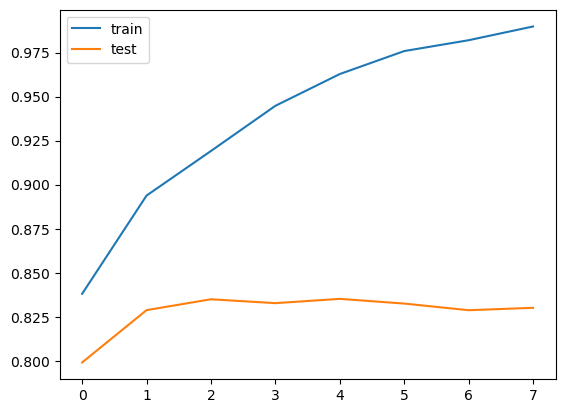

In [12]:
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
	x = np.arange(len(train_accs))

	plt.plot(x, train_accs, label=label1)
	plt.plot(x, test_accs, label=label2)
	plt.legend()
	plt.show()

# 과제: 학습을 진행한 후, epoch에 따른 model의 train과 test data에 대한 정확도 plot하기
plot_acc(train_accuracy_list, test_accuracy_list)